In [1]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.8.10
pandas==1.5.1
numpy==1.23.4
sklearn==1.1.3
torch==1.13.0+cu117
matplotlib==3.6.2


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
#load data
data = pd.read_csv("E:\GitHub\MasterWork\Data\Day\S&P 500 Historical Data00-20.csv")

In [4]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [5]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
4999,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
4998,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
4997,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
4996,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4995,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [6]:
data.index = data.index[::-1]

In [7]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [8]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2014-01-01')]
special_data.index = data.index[:len(special_data)]

In [9]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%


In [10]:
#change indexes
special_data.set_index('Date', inplace=True)

In [11]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [12]:
special_data.head()

,Price
Date,
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69
2010-01-08,1144.98


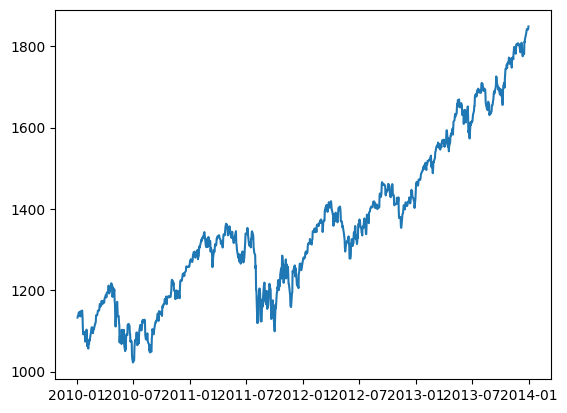

In [13]:
plt.plot(special_data)

In [47]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(special_data)

seq_length = 100
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)).to(device))
dataY = Variable(torch.Tensor(np.array(y)).to(device))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])).to(device))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])).to(device)) 

In [48]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [68]:
num_epochs = 1100
learning_rate = 0.01

input_size = 1
hidden_size = 40
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.18375
Epoch: 100, loss: 0.00053
Epoch: 200, loss: 0.00047
Epoch: 300, loss: 0.00042
Epoch: 400, loss: 0.00039
Epoch: 500, loss: 0.00036
Epoch: 600, loss: 0.00033
Epoch: 700, loss: 0.00031
Epoch: 800, loss: 0.00030
Epoch: 900, loss: 0.00030
Epoch: 1000, loss: 0.00030


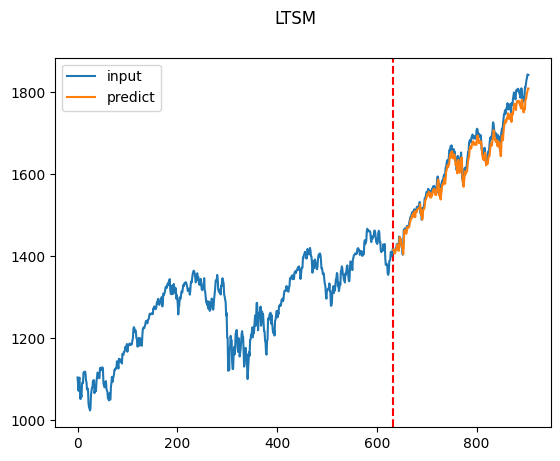

In [69]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.to("cpu").numpy()
dataY_plot = dataY.data.to("cpu").numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x = train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label = 'input')
plt.plot(np.arange(len(dataY_plot) - len(data_predict), len(dataY_plot)), data_predict, label = 'predict')
plt.legend()
plt.suptitle('LTSM')
plt.show()